# Lending - Process Mining
This data illustrates the steps within a loan application process. From an initial appointment request, the process navigates various stages, including information verification and underwriting, culminating in loan approval or denial. Additional steps may be required, such as co-signer enlistment or collateral assessment. Some cases experience outright appointment denial, indicating the process's variability, reflecting applicants' differing credit situations.
The logs' attributes can aid in identifying influences on outcomes and detecting discrimination. Personal characteristics ('age', 'citizen', 'German speaking', and 'gender') and socio-economic indicators ('YearsOfEducation' and 'CreditScore') can impact the process. While 'yearsOfEducation' and 'CreditScore' can validly inform creditworthiness, 'age', 'citizen', 'language ability', and 'gender' should not bias loan decisions, ensuring these attributes are used responsibly fosters equitable loan processes.

## Prequisites
We are going to use :
* pandas
* graphviz
* pm4py
to extract revelant data from these logs using Process Mining.

We first need to install our dependencies (librairies) and import our dataset and prepare it for Process Mining.

### Importing our librairies
We will import all librairies we are going to use in this application.

In [1]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_algorithm
from pm4py.algo.evaluation.precision import algorithm as precision_algorithm
from pm4py.algo.evaluation.generalization import algorithm as generalization_algorithm
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_algorithm
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer

### Importing our dataset, cleaning it (if needed) and transforming it.
We must import our dataset.

In [2]:
# Step 1: Import the XES log file
log = xes_importer.apply("datasets/lending_log_high.xes")

/Users/clementcombier/ProjectsDatabases/venv/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/10000 [00:00<?, ?it/s]

---

## Process Mining
### Explaining our workflow

For our Process Mining of the hiring dataset, we are going to split our workflow into three parts : 
1. Discover a process model using Inductive Miner
2. Visualize the process model
3. Quality measures

### Step 1 : Discover a process model using Inductive Miner
The first part is to create our model from the dataset using Inductive Miner in order to discover a model process.

In [3]:
# We are using one of pm4py's many available method in order to discover our process model.
# Discover a process tree using the Inductive Miner algorithm
tree = pm4py.discover_process_tree_inductive(log,
                                                     activity_key='concept:name',
                                                     timestamp_key='time:timestamp',
                                                     case_id_key='case:concept:name')
# Convert the ProcessTree to a Petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

/Users/clementcombier/ProjectsDatabases/venv/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


### Step 2 : Visualize the process model
Now, we want to visualize our process model to see if our model is correct or not at a first glance.
Thanks to pm4py many methods, we will use them to make three visualization of our model.
1. A Petri Net
2. A Process Tree
3. A BPMN

#### Petri net

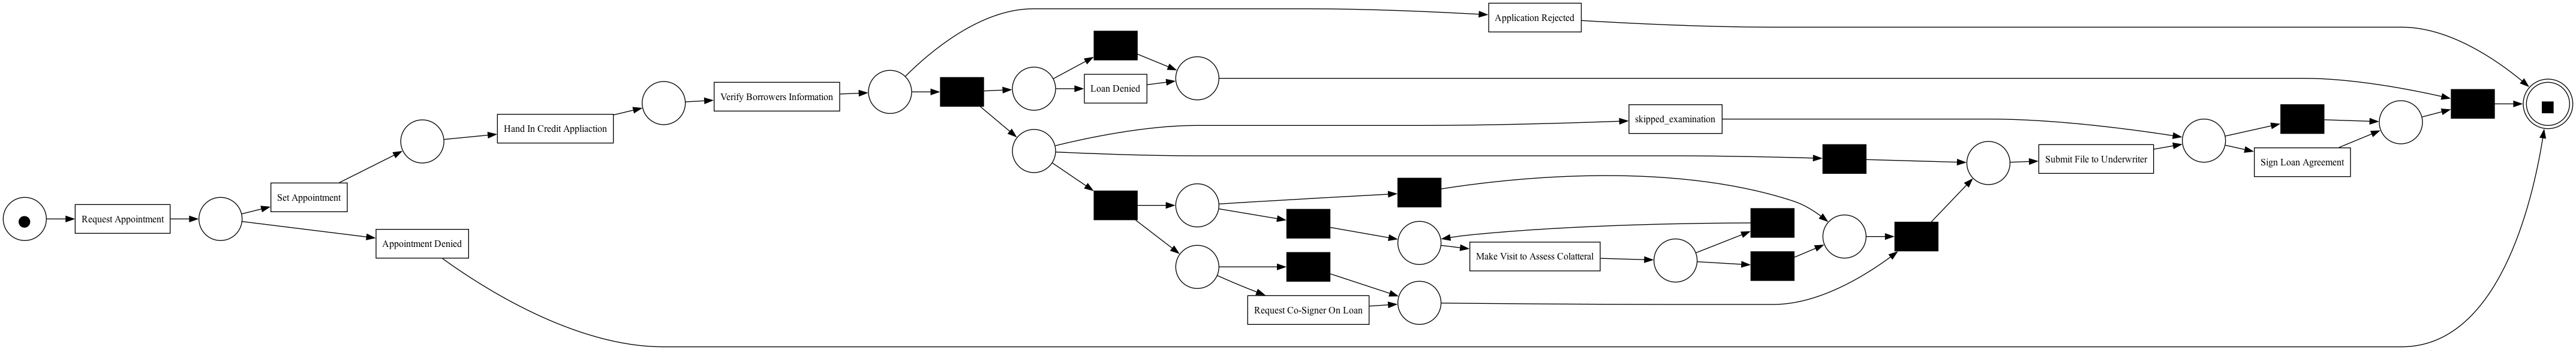

In [4]:
# Visualize as a Petri net
gviz_petri = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz_petri)

#### Process tree

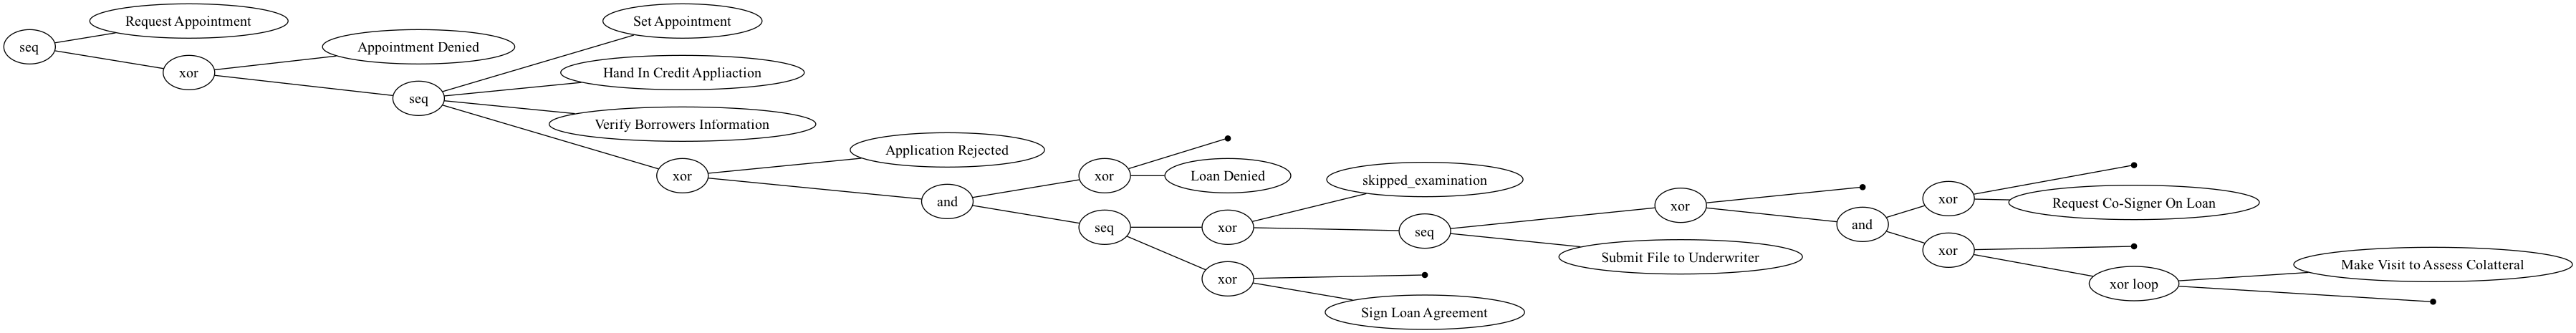

In [5]:
# Visualize as a process tree
gviz_tree = pt_visualizer.apply(tree)
pt_visualizer.view(gviz_tree)

#### BPMN

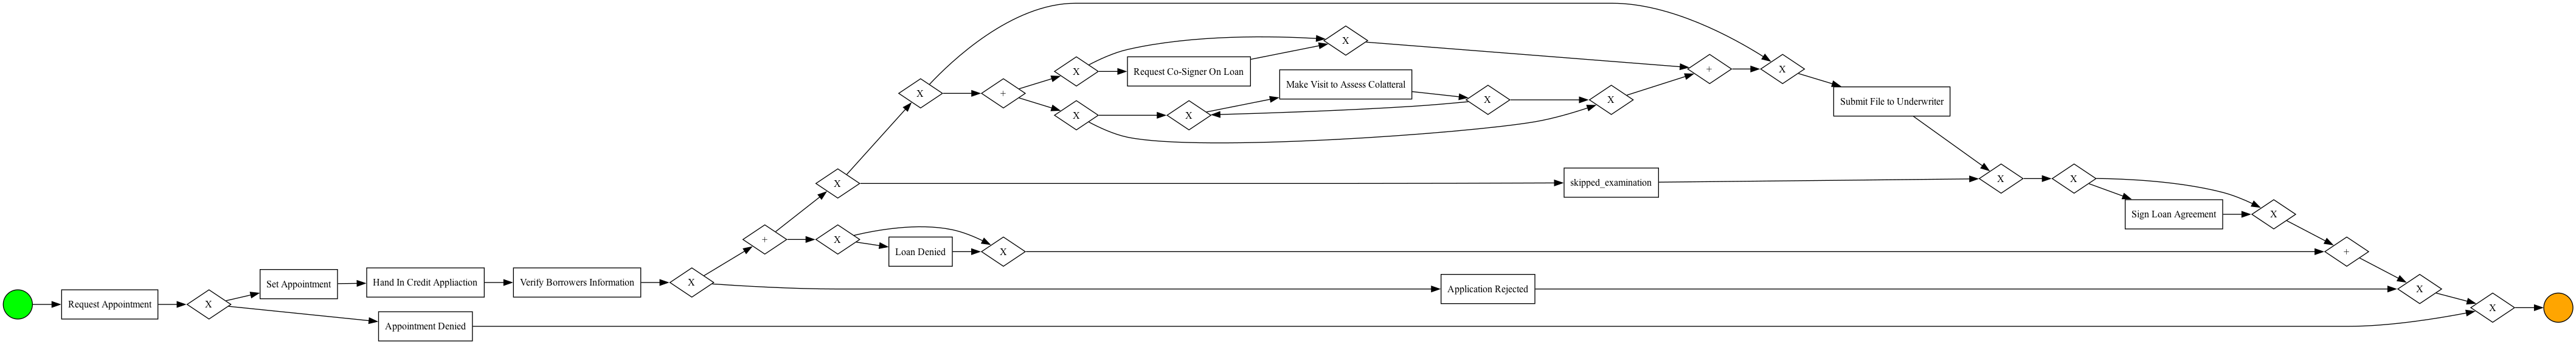

In [6]:
# Convert to BPMN and visualize
bpmn_graph = pm4py.convert_to_bpmn(tree)
gviz_bpmn = bpmn_visualizer.apply(bpmn_graph)
bpmn_visualizer.view(gviz_bpmn)

### Step 3 : Quality measures
We do want to check if our model is fitting the log and is correct. For these, we are going to calculate :
1. Fitness
2. Precision
3. Generalization
4. Simplicity

In [7]:
# Replay Fitness Evaluation (using token-based replay)
fitness = replay_fitness_algorithm.apply(log, net, initial_marking, final_marking, variant=replay_fitness_algorithm.Variants.TOKEN_BASED)

# Precision Evaluation
precision = precision_algorithm.apply(log, net, initial_marking, final_marking)

# Generalization Evaluation
generalization = generalization_algorithm.apply(log, net, initial_marking, final_marking)

# Simplicity Evaluation
simplicity = simplicity_algorithm.apply(net)


# Print the quality measures
print(f"Fitness: {fitness}")
print(f"Precision: {precision}")
print(f"Generalization: {generalization}")
print(f"Simplicity: {simplicity}")

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision: 0.8945986468076685
Generalization: 0.9784947808129482
Simplicity: 0.6774193548387096


### Step 4 : Analysing our result
#### Analysing the Fitness of our model
* **Percentage of traces that fit the model** = 100%; It seems that every traces in our log can be exactly replicated by our modal.
* **Log fitness** = 1; Perfect fitting!
* **Average fitness of each traces in the log** = 1; It seems our traces conform perfectly to our model.
* **Percentage of fitting traces** = 100%; Similar to the percentage of traces that fit the model. A result of 100% tells us traces fit our model!

#### Analysing the Precision of our model
* **Precision** = 0.894 ≃ 90%; A good result for the precision of our model. It is estimated that it's precise at 90% for our traces.

#### Analysing the Generalization of our moddel
* **Generalization** = 0.978 ≃ 98%; Another good result, it seems that in 98% of cases our model is able to handle cases that are similar but still different from what's it used to.

#### Analysing the Simplicity of our moddel
* **Simplicity** = 0.677 ≃ 68%; This result could be higher. Our model is moderatly simple. You may need some times or prior knowledge to correctly understand our model.